#**4_Model performance & evaluation**
This notebook is used to evaluate the performance of two models from hugging face on two datasets that have been preprocessed by BERT on slang word replecement.

# Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Parameters for the notebook

In [2]:
pd.set_option('display.max_colwidth', None)
# TO RUN LOCALLY OR ON COLAB
is_local = False

# Reading in preprocessed data

In [3]:
if is_local == False:
    from google.colab import drive
    drive.mount('/content/drive/')
    path_data = "/content/drive/My Drive/NLP_PROJECT/data/"
else:
    path_data = "D:/Google Drive/NLP_PROJECT/data/"

Mounted at /content/drive/


In [5]:
def read_and_merge_data():
    # datasets
    df_amazon_bert_with_slang= pd.read_csv(path_data + "BERT_data/amazon_bert_with_slang.csv").drop_duplicates(subset=['text'])
    df_amazon_bert_wo_slang= pd.read_csv(path_data + "BERT_data/amazon_bert_wo_slang.csv").drop_duplicates(subset=['text'])
    df_twitter_roberta_with_slang= pd.read_csv(path_data + "BERT_data/twitter_roberta_with_slang.csv").drop_duplicates(subset=['text'])
    df_twitter_roberta_wo_slang= pd.read_csv(path_data + "BERT_data/twitter_roberta_wo_slang.csv").drop_duplicates(subset=['text'])
    # column names
    print("columns:", list(df_twitter_roberta_with_slang.columns))
    df_twitter_roberta = df_twitter_roberta_with_slang.merge(df_twitter_roberta_wo_slang[['text', 'predicted_sentiment']],
                                                                on='text',
                                                                how='left',
                                                                suffixes=('_slang_replaced', '_slang_not_replaced'))
    print("df_twitter_roberta shape:", df_twitter_roberta.shape)
    df_amazon_bert = df_amazon_bert_with_slang.merge(df_amazon_bert_wo_slang[['text', 'predicted_sentiment']],
                                                        on='text',
                                                        how='left',
                                                        suffixes=('_slang_replaced', '_slang_not_replaced'))
    print("df_amazon_bert shape:", df_amazon_bert.shape)
    return df_twitter_roberta, df_amazon_bert

df_twitter_roberta, df_amazon_bert = read_and_merge_data()

columns: ['id', 'true_sentiment', 'text', 'chosen_translation', 'processed_text', 'is_same_as_original', 'predicted_sentiment']
df_twitter_roberta shape: (25480, 8)
df_amazon_bert shape: (3775, 8)


# **[Twitter dataset](https://www.kaggle.com/datasets/gogylogy/twitterslang)** ➡️ binary sentiment classification with **[sentiment-roberta-large-english](https://huggingface.co/siebert/sentiment-roberta-large-english?text=should%27ve+been+asleep+two+hours+ago)**

## Create Confusion Matrix Twitter






In [ ]:
def create_confusion_matrix(df, is_replaced, title):
  col = 'predicted_sentiment_slang_not_replaced'
  if (is_replaced):
    col = 'predicted_sentiment_slang_replaced'

  cf_matrix = confusion_matrix(df['true_sentiment'], df[col])
  #print(cf_matrix)
  group_names = ["TN","FP",
                 "FN","TP"]
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  plt.figure(figsize=(4, 2.5))  # Adjust the figure size as needed
  sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',)
  plt.title(title)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

  create_metrics(df, is_replaced)


#create further metrics
def create_metrics(df, is_replaced):

    col = 'predicted_sentiment_slang_not_replaced'
    if (is_replaced):
      col = 'predicted_sentiment_slang_replaced'
    y_false = (df['true_sentiment']==0).sum()
    y_true = (df['true_sentiment']==1).sum()
    yhat_false = (df[col]==0).sum()
    yhat_true = (df[col]==1).sum()
    scores = [0,1]
    y_list = [y_false, y_true]
    yhat_list = [yhat_false, yhat_true]
    data = {'Actual (y)': y_list, 'Predicted (yhat)': yhat_list}
    df_overview = pd.DataFrame(data)
    df_overview = df_overview.T
    df_overview.columns = scores
    print()
    display(df_overview)
    print()
    print("-----------------------------------------------------------------------------------------------------------------")
    print("Data records:", len(df))
    print()
    print("Actual y=0 --> TN+FP:",y_false)
    print("Actual y=1 --> FN+TP:", y_true)
    print("Predicted y=0 --> TN+FN:",yhat_false)
    print("Predicted y=1 --> FP+TP:",yhat_true)
    print()
    print("Correctly Classified --> TN+TP:", (df['true_sentiment']==df[col]).sum())
    print("Misclassified --> FP+FN:", (df['true_sentiment']!=df[col]).sum())
    print()
    print("Accuracy = (TP+TN)/(TP+FP+TN+FN):", round(accuracy_score(df["true_sentiment"], df[col]),3))  #How many correct, out of all decisions
    print("Precision = TP/(TP+FP):", round(precision_score(df["true_sentiment"], df[col]),3)) #How many are correct, out of cases that the model says are positive?
    print("Recall = TP/(TP+FN):", round(recall_score(df["true_sentiment"], df[col]),3)) #How many positive cases did the model miss, out of all cases that are in fact positive?
    print("F1-Score = 2*(Precision*Recall)/Precision+Recall):", round(f1_score(df["true_sentiment"], df[col]),3)) #Balances recall and precision
    print("-----------------------------------------------------------------------------------------------------------------")

## Confusion Matrix for original tweets (no replacements)

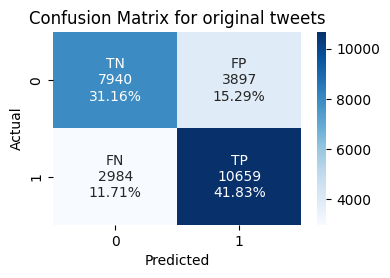

,0,1
Actual (y),11837,13643
Predicted (yhat),10924,14556



-----------------------------------------------------------------------------------------------------------------
Data records: 25480

Actual y=0 --> TN+FP: 11837
Actual y=1 --> FN+TP: 13643
Predicted y=0 --> TN+FN: 10924
Predicted y=1 --> FP+TP: 14556

Correctly Classified --> TN+TP: 18599
Misclassified --> FP+FN: 6881

Accuracy = (TP+TN)/(TP+FP+TN+FN): 0.73
Precision = TP/(TP+FP): 0.732
Recall = TP/(TP+FN): 0.781
F1-Score = 2*(Precision*Recall)/Precision+Recall): 0.756
-----------------------------------------------------------------------------------------------------------------


In [ ]:
#df_twitter_roberta.head()
create_confusion_matrix(df_twitter_roberta, is_replaced=False, title="Confusion Matrix for original tweets")

## Confusion Matrix for tweets with slang/chat word replacements





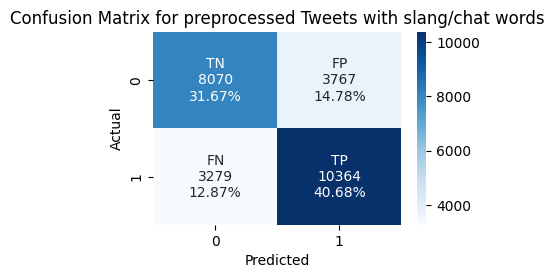

,0,1
Actual (y),11837,13643
Predicted (yhat),11349,14131



-----------------------------------------------------------------------------------------------------------------
Data records: 25480

Actual y=0 --> TN+FP: 11837
Actual y=1 --> FN+TP: 13643
Predicted y=0 --> TN+FN: 11349
Predicted y=1 --> FP+TP: 14131

Correctly Classified --> TN+TP: 18434
Misclassified --> FP+FN: 7046

Accuracy = (TP+TN)/(TP+FP+TN+FN): 0.723
Precision = TP/(TP+FP): 0.733
Recall = TP/(TP+FN): 0.76
F1-Score = 2*(Precision*Recall)/Precision+Recall): 0.746
-----------------------------------------------------------------------------------------------------------------


In [ ]:
create_confusion_matrix(df_twitter_roberta, is_replaced=True, title="Confusion Matrix for preprocessed Tweets with slang/chat words")

# **[Amazon Product Review dataset](https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews)** ➡️ 1-5 classification with **[bert-base-multilingual-uncased-sentiment](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment)**

## Create Confusion Matrix Amazon


In [ ]:
#https://www.v7labs.com/blog/confusion-matrix-guide
def create_confusion_matrix2(df, is_replaced, title):
  col = 'predicted_sentiment_slang_not_replaced'
  if (is_replaced):
    col = 'predicted_sentiment_slang_replaced'

  cf_matrix = confusion_matrix(df['true_sentiment'], df[col])
  group_names = ["T?","F?","F?","F?","F?",
                 "F?","T?","F?","F?","F?",
                 "F?","F?","T?","F?","F?",
                 "F?","F?","F?","T?","F?",
                 "F?","F?","F?","F?","T?",]
  #group_names = ["TN", "FP", "FP", "FP", "FP",
              # "FN", "TP", "FP", "FP", "FP",
              # "FN", "FP", "TP", "FP", "FP",
              # "FN", "FP", "FP", "TP", "FP",
              # "FN", "FP", "FP", "FP", "TP"]
 #suggested by one website --> to be neglected
  #group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  #group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  #labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  #labels = np.asarray(labels).reshape(5,5)
  scores = [1,2,3,4,5]
  plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
  sns.heatmap(cf_matrix, annot=True, xticklabels=scores, yticklabels=scores, cmap='Blues', fmt='')
  plt.title(title)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

#create further metrics
def create_metrics2(df, is_replaced, average):
    col = 'predicted_sentiment_slang_not_replaced'
    if (is_replaced):
      col = 'predicted_sentiment_slang_replaced'

    y_1 = (df['true_sentiment']==1).sum()
    y_2 = (df['true_sentiment']==2).sum()
    y_3 = (df['true_sentiment']==3).sum()
    y_4 = (df['true_sentiment']==4).sum()
    y_5 = (df['true_sentiment']==5).sum()
    yhat_1 = (df[col]==1).sum()
    yhat_2 = (df[col]==2).sum()
    yhat_3 = (df[col]==3).sum()
    yhat_4 = (df[col]==4).sum()
    yhat_5 = (df[col]==5).sum()
    scores = [1,2,3,4,5]
    y_list = [y_1,y_2,y_3,y_4,y_5]
    yhat_list = [yhat_1,yhat_2,yhat_3,yhat_4,yhat_5]
    data = {'Actual (y)': y_list, 'Predicted (yhat)': yhat_list}
    df_overview = pd.DataFrame(data)
    df_overview = df_overview.T
    df_overview.columns = scores
    print()
    print()
    display(df_overview)
    print()
    print()
    precision_list = list(precision_score(df["true_sentiment"], df[col], average=average))
    recall_list = list(recall_score(df["true_sentiment"], df[col], average=average))
    f1_score_list = list(f1_score(df["true_sentiment"], df[col], average=average))
    df_metrics = pd.DataFrame(precision_list, columns=['Precision = TP/(TP+FP)']) #How many are correct, out of cases that the model says are positive?
    df_metrics['Recall = TP/(TP+FN)'] = recall_list #How many positive cases did the model miss, out of all ca
    df_metrics['F1-Score = 2*(Precision*Recall)/Precision+Recall)'] = f1_score_list #Balances recall and precision
    display(df_metrics)
    print()
    print("-----------------------------------------------------------------------------------------------------------------")
    print("Data records:", len(df))
    print()
    print("Accuracy = (TP+TN)/(TP+FP+TN+FN):", round(accuracy_score(df["true_sentiment"], df[col]),2))  #How many correct, out of all decisions
    print("-----------------------------------------------------------------------------------------------------------------")




## Confusion Matrix for original Amazon Product Revies (no replacements)



In [ ]:
#df_amazon_bert.head()

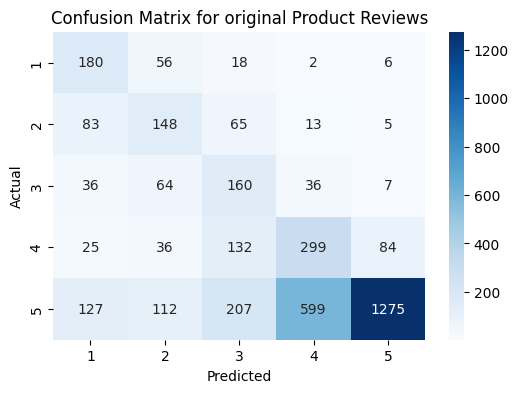

,1,2,3,4,5
Actual (y),262,314,303,576,2320
Predicted (yhat),451,416,582,949,1377


,Precision = TP/(TP+FP),Recall = TP/(TP+FN),F1-Score = 2*(Precision*Recall)/Precision+Recall)
0,0.399113,0.687023,0.504909
1,0.355769,0.471338,0.405479
2,0.274914,0.528053,0.361582
3,0.315068,0.519097,0.392131
4,0.925926,0.549569,0.689748



-----------------------------------------------------------------------------------------------------------------
Data records: 3775

Accuracy = (TP+TN)/(TP+FP+TN+FN): 0.55
-----------------------------------------------------------------------------------------------------------------


In [ ]:
create_confusion_matrix2(df_amazon_bert, is_replaced=False, title="Confusion Matrix for original Product Reviews")
create_metrics2(df=df_amazon_bert, is_replaced=False, average=None)

## Confusion Matrix for Amazon Product reviews with slang/chat word replacements


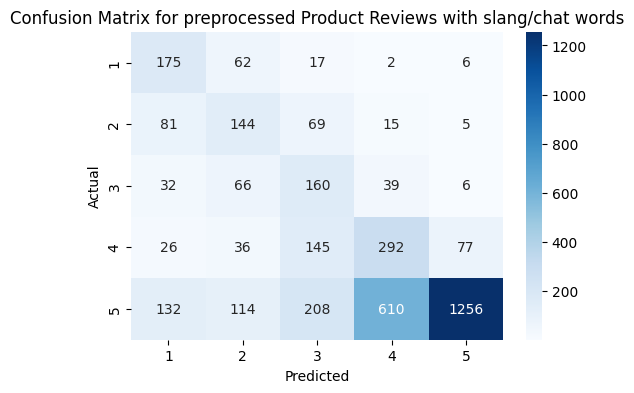

,1,2,3,4,5
Actual (y),262,314,303,576,2320
Predicted (yhat),446,422,599,958,1350


,Precision = TP/(TP+FP),Recall = TP/(TP+FN),F1-Score = 2*(Precision*Recall)/Precision+Recall)
0,0.392377,0.667939,0.494350
1,0.341232,0.458599,0.391304
2,0.267112,0.528053,0.354767
3,0.304802,0.506944,0.380704
4,0.930370,0.541379,0.684469



-----------------------------------------------------------------------------------------------------------------
Data records: 3775

Accuracy = (TP+TN)/(TP+FP+TN+FN): 0.54
-----------------------------------------------------------------------------------------------------------------


In [ ]:
create_confusion_matrix2(df_amazon_bert, is_replaced=True, title="Confusion Matrix for preprocessed Product Reviews with slang/chat words")
create_metrics2(df_amazon_bert, is_replaced=True, average=None)